# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam.
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**: Mir Mohibullah Sazid

**Neptun code:** GVFPV8

**Date:** 14/01/2025 9AM-11AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-image Diffusion like model, and the forward function. The model receives an intial image and a text as input (describes how the final image should look like) and generates an image according to the two.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1VWSuYR0Msa6M8FWnMJug3nZnPUytz3dS/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1VWSuYR0Msa6M8FWnMJug3nZnPUytz3dS)


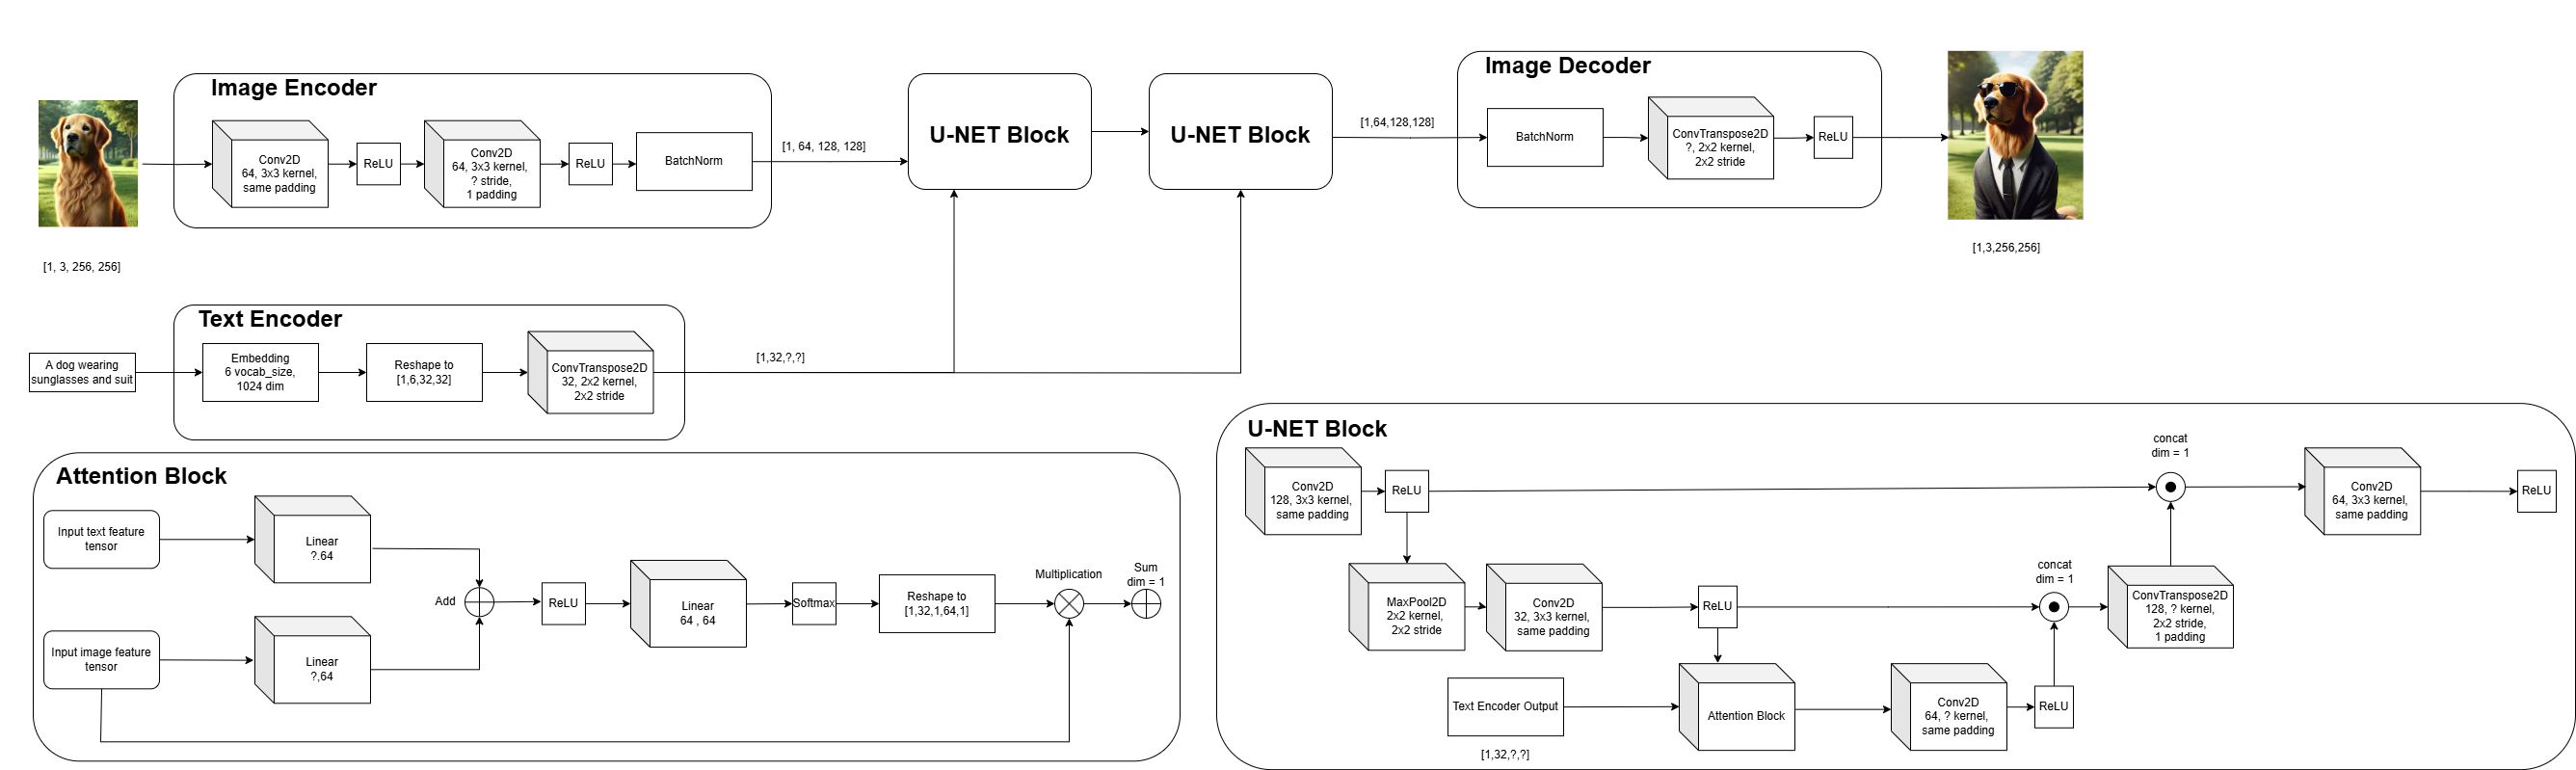


#### Input image: Doge meme
By Atsuko Sato - https://kabosu112.exblog.jp/iv/detail/?s=9944144&i=201002%2F12%2F90%2Fa0126590_22301391.jpg, Fair use, https://en.wikipedia.org/w/index.php?curid=41704519

In [2]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [3]:
image.shape

(3, 256, 256)

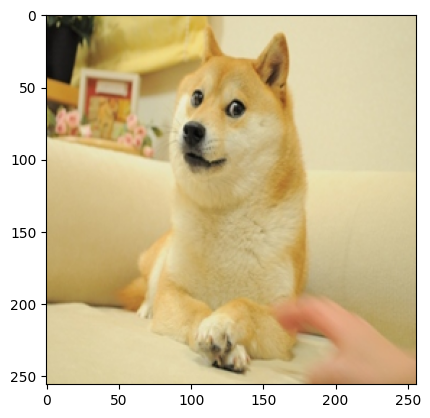

In [4]:
plt.imshow(np.moveaxis(image, 0,-1))

In [5]:
#Simple pre-processing
input_image = torch.tensor(image,dtype=torch.float32)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### Input text

In [6]:
text = "A dog wearing sunglasses and suit"

# Simple preprocessing the text
word_to_ix = {"A": 0, "dog": 1, "wearing": 2, "sunglasses": 3, "and": 4, "suit": 5}
lookup_tensor = torch.tensor(list(word_to_ix.values()), dtype=torch.long) # a tensor representing words by integers

vocab_size = len(lookup_tensor)

In [7]:
vocab_size

6

#### 1.1. Implement the architecture

In [16]:
import torch
import torch.nn as nn

class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)  # Same padding
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=3, stride=2, padding=1)  # Padding of 1
        self.relu2 = nn.ReLU()
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, input_image):
        x = self.conv1(input_image)   # First convolution
        print("1st conv shape", x.shape)
        x = self.relu1(x)             # Apply ReLU
        x = self.conv2(x)             # Second convolution
        print("2nd conv shape", x.shape)
        x = self.relu2(x)             # Apply ReLU
        x = self.batch_norm(x)        # Apply BatchNorm
        return x

# Example usage:
# Input shape: [1, 3, 256, 256] -> [batch_size, channels, height, width]
image_encoder = ImageEncoder(in_channels=3, out_channels=64)
input_image = torch.randn(1, 3, 256, 256)  # Example input
output_features = image_encoder(input_image)
print(output_features.shape)  # Expected output shape: [1, 64, 128, 128]

1st conv shape torch.Size([1, 64, 256, 256])
2nd conv shape torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 128, 128])


In [23]:
import torch
import torch.nn as nn

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=6,  # Reshape determines this
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        )

    def forward(self, input_text):
        input_text = lookup_tensor.unsqueeze(0) 
        # Embed the input text
        x = self.embedding(input_text)  # Shape: [batch_size, seq_len, embedding_dim]
        print("embedding shape", x.shape)

        # Reshape the embeddings to match ConvTranspose2D input
        batch_size = x.shape[0]
        x = x.view(batch_size, -1, 32, 32)  # Shape: [batch_size, embedding_dim // (32*32), 32, 32]
        print("reshaped embedding shape", x.shape)

        # Apply ConvTranspose2D
        x = self.conv_transpose(x)  # Output shape will depend on kernel/stride of ConvTranspose2D
        print("conv_transpose shape", x.shape)
        return x

# Example usage:
vocab_size = 6
embedding_dim = 1024
out_channels = 32
text_encoder = TextEncoder(vocab_size=vocab_size, embedding_dim=embedding_dim, out_channels=out_channels)

# Example input (batch of tokenized text sequences)
input_text = torch.randint(0, vocab_size, (1, 6))  # Batch size: 1, Sequence length: 6
output_features = text_encoder(input_text)

print(output_features.shape)  # Expected output shape: [1, 32, ?, ?]

embedding shape torch.Size([1, 6, 1024])
reshaped embedding shape torch.Size([1, 6, 32, 32])
conv_transpose shape torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])


In [18]:
import torch
import torch.nn as nn

class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # Define the BatchNorm layer
        self.batch_norm = nn.BatchNorm2d(in_channels)
        
        # Define the ConvTranspose2D layer
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        )
        
        # Define the ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, image_features):
        # Apply BatchNorm
        x = self.batch_norm(image_features)
        
        # Apply ConvTranspose2D
        x = self.conv_transpose(x)
        print("conv", x.shape)
        
        # Apply ReLU
        x = self.relu(x)
        
        return x

# Example usage
decoder = ImageDecoder(in_channels=64, out_channels=3)
image_features = torch.randn(1, 64, 128, 128)  # Example input
output = decoder(image_features)  # Output shape: [1, 3, 256, 256]
print(output.shape)

conv torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, encoder_dim, bottleneck_dim, attention_dim):
        """
        encoder_dim: Flattened size of the text encoder outputs (?)
        bottleneck_dim: Flattened size of the image encoder features (?)
        attention_dim: The "64" from the diagram
        """
        super(Attention, self).__init__()

        # 1) Linear layers to map text -> attention_dim, image -> attention_dim
        self.text_fc = nn.Linear(encoder_dim, attention_dim)
        self.image_fc = nn.Linear(bottleneck_dim, attention_dim)

        # 2) Additional layers per the diagram
        self.relu = nn.ReLU()
        self.fc = nn.Linear(attention_dim, attention_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, text_encoder_outputs, image_encoder_features):
        """
        text_encoder_outputs: [batch_size, 32, 64, 64]
        image_encoder_features: [batch_size, 64, 128, 128]

        Diagram steps:
          - Flatten each -> pass to linear -> add -> ReLU -> linear -> softmax
          - Reshape -> multiply -> sum(dim=1) -> 'context'
        """

        bsz = text_encoder_outputs.size(0)
        print("bsz", bsz)

        # -- Flatten the text and image tensors --
        #   e.g. [1, 32, 64, 64] -> [1, 32*64*64]
        text_flat = text_encoder_outputs.view(bsz, -1)
        print("text_flat shape", text_flat.shape)
        image_flat = image_encoder_features.view(bsz, -1)
        print("image_flat shape", image_flat.shape)

        # -- Pass both through their respective linear layers --
        text_lin = self.text_fc(text_flat)   # -> [bsz, attention_dim]
        print("text_lin shape", text_lin.shape)
        image_lin = self.image_fc(image_flat)  # -> [bsz, attention_dim]

        # -- Add, then ReLU --
        added = text_lin + image_lin         # [bsz, attention_dim]
        print("added shape", added.shape)
        added = self.relu(added)           

        # -- Another linear, then Softmax --
        scores = self.fc(added)             # [bsz, attention_dim]
        scores = self.softmax(scores)       # [bsz, attention_dim]

        # -- Reshape so it can broadcast with text_encoder_outputs --
        #   For example, interpret each of the 'attention_dim' entries as a weight.
        #   Suppose we do [bsz, attention_dim, 1, 1], so we can treat them as
        #   per-channel weights if text_encoder_outputs had 64 channels.
        #   If your text actually has 32 channels, you’ll have to decide how to align them.
        scores_reshaped = scores.view(bsz, -1, 1, 1)  
        print("scores_reshaped shape", scores_reshaped.shape)
        # shape now [bsz, attention_dim, 1, 1], which can multiply with
        # something that also has 'attention_dim' channels.

        # -- Multiply with the original text features. NOTE:
        #   If your text has 32 channels but attention_dim=64, you must decide
        #   which features get multiplied. One approach is to do
        #   “channel = 64” for text so that it lines up. For example:
        weighted = text_encoder_outputs * scores_reshaped[:, :32, :, :] 
        print("weighted shape", weighted.shape)
        # or whichever indexing/broadcast scheme you prefer

        # -- Sum along dim=1 (which is the “channel” dimension here) --
        #   so the final shape might become [bsz, H, W], or [bsz, 1, H, W] if keepdim=True
        context = weighted.sum(dim=1, keepdim=True)
        print("context shape", context.shape)

        return context

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# # -------------------------------------------------------------------------
# # Example Attention (as completed previously)
# # -------------------------------------------------------------------------
# class Attention(nn.Module):
#     def __init__(self, encoder_dim, bottleneck_dim, attention_dim):
#         super(Attention, self).__init__()
#         # Two linear layers: one for the "encoder" feats, one for "bottleneck"
#         self.text_fc = nn.Linear(encoder_dim, attention_dim)
#         self.img_fc  = nn.Linear(bottleneck_dim, attention_dim)

#         self.relu = nn.ReLU()
#         self.fc   = nn.Linear(attention_dim, attention_dim)
#         self.softmax = nn.Softmax(dim=-1)

#     def forward(self, text_feats, image_feats):
#         """
#         text_feats:  [B, text_C, H, W]
#         image_feats: [B, img_C,  H, W]
#         For a standard nn.Linear, flatten first; do (Add->ReLU->Linear->Softmax),
#         then reshape & multiply, sum(dim=1).
#         """
#         bsz = text_feats.size(0)

#         # 1) Flatten
#         text_flat = text_feats.view(bsz, -1)   # [B, text_C*H*W]
#         image_flat = image_feats.view(bsz, -1) # [B, img_C*H*W]

#         # 2) Linear
#         t_lin = self.text_fc(text_flat)   # [B, attention_dim]
#         i_lin = self.img_fc(image_flat)   # [B, attention_dim]

#         # 3) Add -> ReLU -> Linear -> Softmax
#         added = self.relu(t_lin + i_lin)  # [B, attention_dim]
#         scores = self.softmax(self.fc(added))  # [B, attention_dim]

#         # 4) Reshape for elementwise multiplication
#         #    shape as [B, attention_dim, 1, 1], for instance
#         scores_reshaped = scores.view(bsz, -1, 1, 1)

#         # 5) Multiply by the original text_feats (or image_feats)
#         #    Make sure channel counts align: if text_feats has C=32 and
#         #    attention_dim=64, you may need to slice or handle differently.
#         #    Here we assume text_feats also has 64 “channels,” or you adapt as needed:
#         weighted = text_feats * scores_reshaped

#         # 6) Sum over channel dim=1 => final context shape [B, 1, H, W]
#         context = weighted.sum(dim=1, keepdim=True)

#         return context

# -------------------------------------------------------------------------
# Modified MyUNet
# -------------------------------------------------------------------------
class MyUNet(nn.Module):
    def __init__(self, text_in_channels, bottleneck_channels, out_channels, attention_dim):
        """
        text_in_channels: number of channels in text_features (e.g. 32)
        bottleneck_channels: number of channels in image_features (e.g. 64)
        out_channels: final U-Net output channels (e.g. 64 or 3)
        attention_dim: dimension inside Attention (e.g. 64)
        """
        super(MyUNet, self).__init__()

        # --- "Downscaling" part for the image features ---
        # 1) Conv2D 128, 3x3 kernel, same padding
        self.conv1 = nn.Conv2d(bottleneck_channels, 128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # 2) MaxPool2D (2x2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3) Another Conv2D (e.g. 32 out, matching your diagram's "Conv2D 32")
        self.conv2 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # --- Attention block ---
        self.attention = Attention(
            encoder_dim=32*64*64,  # if x2 is [B,32,64,64] then flatten=32*64*64
            bottleneck_dim=text_in_channels*64*64,  # if text feats [B,32,64,64]
            attention_dim=attention_dim
        )

        # --- Another conv after attention (diagram: "Conv2D 64, 3x3") ---
        self.conv3 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  
        # Notice we used "in_channels=1" because the attention we coded
        # returns shape [B,1,H,W]. If you adapt your attention block to
        # return more channels, update this accordingly.

        self.relu3 = nn.ReLU()

        # --- Upscaling part (diagram: "ConvTranspose2D 128, 2x2 kernel, 2x2 stride, 1 padding") ---
        self.upconv = nn.ConvTranspose2d(
            in_channels=96,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )

        # --- Final output convolution (diagram: "Conv2D 64, 3x3, same padding") ---
        # We will concatenate x1 ([B,128,H,W]) with x4 ([B,128,H,W]),
        # so total in_channels=128+128=256
        self.output_conv = nn.Conv2d(128 + 128, out_channels, kernel_size=3, padding=1)
        self.relu_out = nn.ReLU()

    def forward(self, text_features, image_features):
        """
        text_features:  [B, text_in_channels, 64, 64]   (e.g. [1,32,64,64])
        image_features: [B, bottleneck_channels, 128,128] (e.g. [1,64,128,128])
        """

        # ----------------------
        # 1) "Downscale" image
        # ----------------------
        # Conv2D -> ReLU
        x1 = self.conv1(image_features)   # => [B,128,128,128]
        print("x1 shape", x1.shape)
        x1 = self.relu1(x1)

        # Pool -> shape ~ [B,128,64,64]
        x2 = self.pool(x1) 
        print("x2 shape", x2.shape)               
        # Conv2D -> ReLU => [B,32,64,64]
        x2 = self.conv2(x2)
        print("x2 shape", x2.shape)
        x2 = self.relu2(x2)

        # --------------------------------------------------------
        # 2) Attention with the text features
        #    (Your diagram indicates you pass x2 + text together)
        # --------------------------------------------------------
        att_out = self.attention(x2, text_features)  
        print("att_out shape", att_out.shape)
        # e.g. shape [B,1,64,64] if we coded our Attention that way

        # ---------------------------------------
        # 3) One more conv after attention block
        # ---------------------------------------
        x3 = self.conv3(att_out)          # => [B,64,64,64]
        print("x3 shape", x3.shape)
        x3 = self.relu3(x3)

        y = torch.cat([x2, x3], dim=1)  # Concatenate along channel dim
        print("y shape", y.shape)
        # ----------------------------------------------
        # 4) Upscale with TransposedConv => [B,128,128,128]
        # ----------------------------------------------
        x4 = self.upconv(y)
        print("x4 shape", x4.shape)

        # ------------------------------------------------------------
        # 5) Skip connection: concat (x1 from early) with the upsample
        #    => [B,128+128=256, 128, 128]
        # ------------------------------------------------------------
        x5 = torch.cat([x1, x4], dim=1)
        print("x5 shape", x5.shape)

        # ------------------------------------------------
        # 6) Final conv => out_channels + ReLU => done
        # ------------------------------------------------
        x6 = self.output_conv(x5)         # => [B,out_channels,128,128]
        print("x6 shape", x6.shape)
        x6 = self.relu_out(x6)

        return x6

In [21]:
class ImageToImageGenerator(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        image_channels,
        text_encoder_out_channels,
        image_encoder_out_channels,
        unet_out_channels,
        attention_dim
    ):
        """
        Example usage:
          vocab_size=6,
          embedding_dim=1024,
          image_channels=3,
          text_encoder_out_channels=32,
          image_encoder_out_channels=64,
          unet_out_channels=64,
          attention_dim=64
        """
        super(ImageToImageGenerator, self).__init__()
        
        self.text_encoder = TextEncoder(
            vocab_size, embedding_dim, text_encoder_out_channels
        )
        self.image_encoder = ImageEncoder(
            in_channels=image_channels, out_channels=image_encoder_out_channels
        )
        self.unet = MyUNet(
            text_in_channels=text_encoder_out_channels,
            bottleneck_channels=image_encoder_out_channels,
            out_channels=unet_out_channels,
            attention_dim=attention_dim
        )
        self.image_decoder = ImageDecoder(
            in_channels=unet_out_channels, out_channels=image_channels
        )

    def forward(self, input_text, input_image):
        """
        1) Encode text
        2) Encode image
        3) Pass both to UNet
        4) Decode the UNet’s output back to an image
        """
        # 1) TEXT ENCODER
        text_features = self.text_encoder(input_text)
        
        # 2) IMAGE ENCODER
        image_features = self.image_encoder(input_image)
        
        # 3) UNet
        unet_out = self.unet(text_features, image_features)
        
        # 4) IMAGE DECODER
        generated_image = self.image_decoder(unet_out)
        
        return generated_image

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [33]:
#DONT MODIFY THIS BLOCK
########################################################
# vocab_size = vocab_size
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
attention_dim= 64
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels,attention_dim)

input_text = lookup_tensor

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)

embedding shape torch.Size([1, 6, 1024])
reshaped embedding shape torch.Size([1, 6, 32, 32])
conv_transpose shape torch.Size([1, 32, 64, 64])
1st conv shape torch.Size([1, 64, 256, 256])
2nd conv shape torch.Size([1, 64, 128, 128])
x1 shape torch.Size([1, 128, 128, 128])
x2 shape torch.Size([1, 128, 64, 64])
x2 shape torch.Size([1, 32, 64, 64])
bsz 1
text_flat shape torch.Size([1, 131072])
image_flat shape torch.Size([1, 131072])
text_lin shape torch.Size([1, 64])
added shape torch.Size([1, 64])
scores_reshaped shape torch.Size([1, 64, 1, 1])
weighted shape torch.Size([1, 32, 64, 64])
context shape torch.Size([1, 1, 64, 64])
att_out shape torch.Size([1, 1, 64, 64])
x3 shape torch.Size([1, 64, 64, 64])
y shape torch.Size([1, 96, 64, 64])
x4 shape torch.Size([1, 128, 128, 128])
x5 shape torch.Size([1, 256, 128, 128])
x6 shape torch.Size([1, 64, 128, 128])
conv torch.Size([1, 3, 256, 256])
----------------------------------------------------------------
Output Image Shape: torch.Size([1, 

For fun -- check the generated image, it should look something like this: https://drive.google.com/file/d/1NW3FwNSUj6bCyJd1TFvJUspLdmxR94m5/view?usp=sharing

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1NW3FwNSUj6bCyJd1TFvJUspLdmxR94m5)


**Optional part for +1 grade**

Implement the architecture bellow:
https://drive.google.com/file/d/1TuIYbSp25FPazJMUMoAEdf12SoW-wkEh/view?usp=sharing

![](https://drive.google.com/uc?export=view&id=1TuIYbSp25FPazJMUMoAEdf12SoW-wkEh)


In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels):
        super(TextEncoder, self).__init__()
        # DEFINE the layers


    def forward(self, input_text):
        x=input_text
        # EMBED the input text

        # RESHAPE the embeddings and SEND them to the next layer

        return x


class ImageEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageEncoder, self).__init__()
        # DEFINE the layers


    def forward(self, input_image): # [1,3,256,256]
        # SEND the input image and then the features to the given layers
        x=input_image
        return x


class ImageDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImageDecoder, self).__init__()
        # DEFINE the layers


    def forward(self, image_features):
       # SEND the input image and then the features to the given layers
        x=image_features

        return x


class MyUNet(nn.Module):
    def __init__(self, text_in_channels, bottleneck_channels, out_channels, attention_dim):
        super(MyUNet, self).__init__()
         # DEFINE the layers


    def forward(self, text_features, image_features):
        # SEND the text_features to the first conv2d layer (this output is needed to combination)
        x=image_features
        # SEND to the pooling layer

        # SEND to the secound conv layer (this output is also needed to a combination)

        # Send to the Cross-Attention layer with the image_features

        # SEND to the third conv layer

        # COMBINE the output of the secound conv layer and the output of the third conv layer (dim=1)

        # Send to the transposedconv2d layer

        # COMBINE the output of the transposed2d layer and the first conv layer output (dim=1)


        # SEND the COMBINED features to the last Conv2d and ReLU layer of the U-Net

        return x


class ImageToImageGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels, attention_dim): # 6, 1024, 3, 32, 64, 64, 64
        super(ImageToImageGenerator, self).__init__()
        # DEFINE the layers


    def forward(self, input_text, input_image):
        generated_image=input_text
        # SEND the input text to the TEXT ENCODER

        # SEND the input image to the IMAGE ENCODER

        # SEND the text_features and image_features to the U-NET

        # SEND the IMAGE FETURES from the U-NET to the IMAGE DECODER

        #return the image
        return generated_image


class CrossAttention(nn.Module):
    def __init__(self, embed_dim=1024, input_size_image=4096,input_size_text=4096):
        super(CrossAttention, self).__init__()
        # DEFINE the layers


    def forward(self, text_embedding, image_embedding):
        out=image_embedding
        # Flatten spatial dimensions (height, width) into sequence length


        # Compute Q, K, V


        # Compute attention scores


        # Compute weighted sum of values


        # Send to the output transformation


        # Reshape output back to original spatial dimensions

        return out

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 3, 256, 256] )

In [ ]:
#DONT MODIFY THIS BLOCK
########################################################
embedding_dim = 1024
image_channels = 3
text_encoder_out_channels = 32
image_encoder_out_channels = 64
unet_out_channels = 64
attention_dim= 1024
model = ImageToImageGenerator(vocab_size, embedding_dim, image_channels, text_encoder_out_channels, image_encoder_out_channels, unet_out_channels,attention_dim)

input_text = lookup_tensor
# input_image = input_image

# Forward pass
output = model(input_text, input_image)
print('----------------------------------------------------------------')
print("Output Image Shape:", output.shape)
#########################################################

In [ ]:

%matplotlib inline

rgb_array = output[0].permute(1, 2, 0).detach().numpy()
rgb_array = rgb_array.clip(0, 1)
plt.imshow(rgb_array)


# Extra Task for AI-lab: Pairing Images and Texts

In this task, the goal is to pairs 4 images with 4 texts using Hugging Face models and a Gradio interface. The system ensures no duplicate images or texts are inputted, generates embeddings for both (images and texts), and matches them based on semantic similarity, then printing the pairs.